# Tackle the Titanic dataset

Exercise: _Tackle the Titanic dataset. A great place to start is on [Kaggle](https://www.kaggle.com/c/titanic). Alternatively, you can download the data from https://homl.info/titanic.tgz and unzip this tarball like you did for the housing data in Chapter 2. This will give you two CSV files: _train.csv_ and _test.csv_ which you can load using `pandas.read_csv()`. The goal is to train a classifier that can predict the `Survived` column based on the other columns._

In [275]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, make_pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, accuracy_score


In [2]:
#| echo: false

# set the theme for seaborn

sns.set_theme()

# set the theme for matplotlib.pyplot:



In [164]:
#| echo: false

# for saving the images for the blog

# only run in the blog_version!!!

from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [165]:
df = pd.read_csv("../data/titanic/train.csv")

In [166]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## EDA

Take a look at the data structure

In [274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    object 
 5   Age            714 non-null    float64
 6   SibSp          891 non-null    int64  
 7   Parch          891 non-null    int64  
 8   Ticket         891 non-null    object 
 9   Fare           891 non-null    float64
 10  Cabin          204 non-null    object 
 11  Embarked       889 non-null    object 
 12  Cabin_present  891 non-null    int32  
 13  is_doctor      891 non-null    int32  
dtypes: float64(2), int32(2), int64(5), object(5)
memory usage: 90.6+ KB


Check for missing values

In [275]:
df.isnull().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age              177
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin            687
Embarked           2
Cabin_present      0
is_doctor          0
dtype: int64

### Check the balance of the label

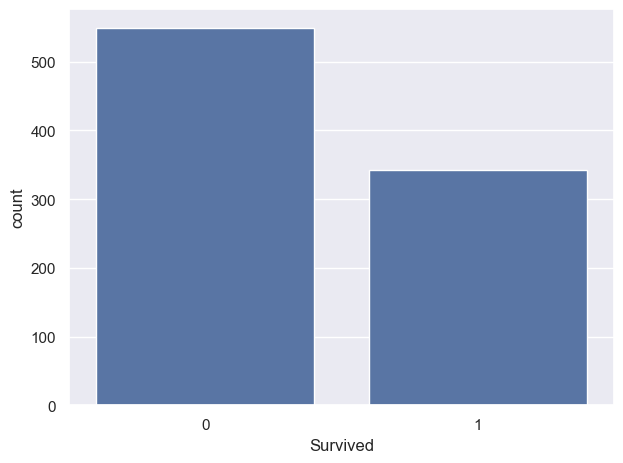

In [168]:
# Insights:
# Less survivors than non-survivors
# -> unbalanced label

sns.barplot(df["Survived"].value_counts())
save_fig("survivors")


### Age distibution

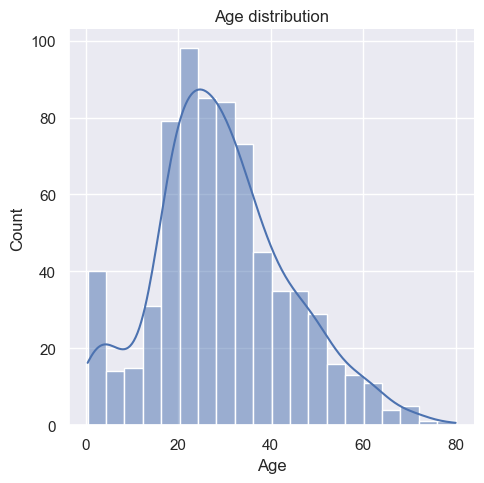

In [220]:
sns.displot(df, x="Age", kde=True)
plt.title("Age distribution")
save_fig("age_distribution")

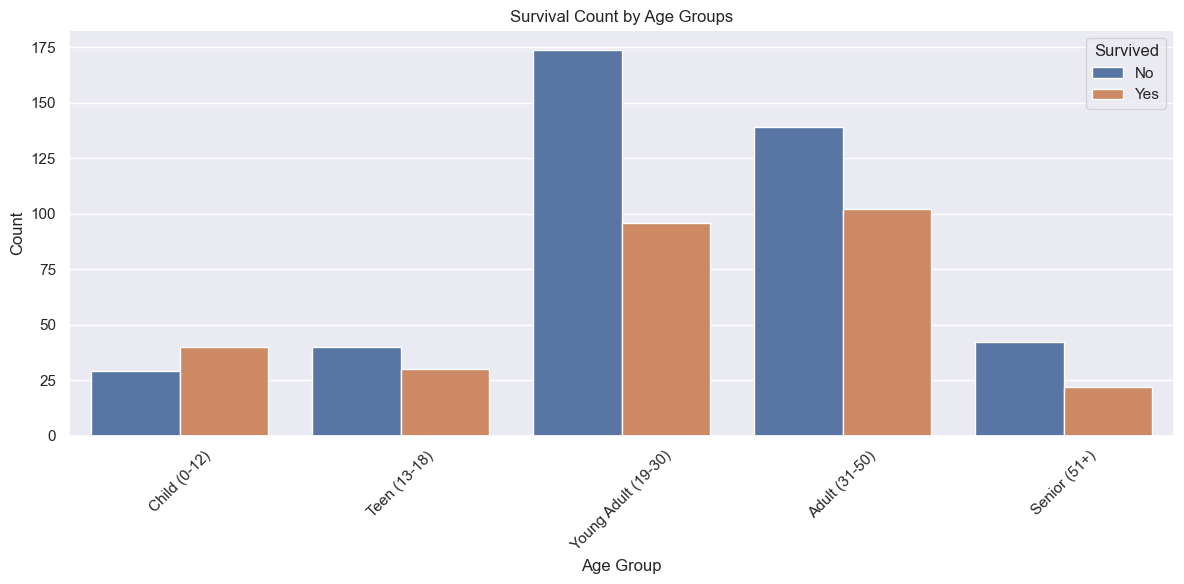

In [ ]:
# Insights:
# Children (0–12) had the best odds: more survived than died, consistent with a “children first” effect
# Young Adults (19–30) had the highest death count and a relatively low survival rate.

# Histogram with hue for survival by age
plt.figure(figsize=(12, 6))

# Create age groups for better analysis
df["AgeGroup"] = pd.cut(df["Age"], bins=[0, 12, 18, 30, 50, 80], 
                       labels=["Child (0-12)", "Teen (13-18)", "Young Adult (19-30)", 
                              "Adult (31-50)", "Senior (51+)"], include_lowest=True)

# Plot survival by age groups
sns.countplot(data=df, x="AgeGroup", hue="Survived")
plt.title("Survival Count by Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.xticks(rotation=45)
save_fig("survival_by_age")


In [182]:
# survival rate by AgeGroup

survival_rates = pd.Series(df.groupby("AgeGroup", observed=True)["Survived"].mean())
survival_rates

AgeGroup
Child (0-12)           0.579710
Teen (13-18)           0.428571
Young Adult (19-30)    0.355556
Adult (31-50)          0.423237
Senior (51+)           0.343750
Name: Survived, dtype: float64

In [194]:
survival_rates.values

array([0.57971014, 0.42857143, 0.35555556, 0.42323651, 0.34375   ])

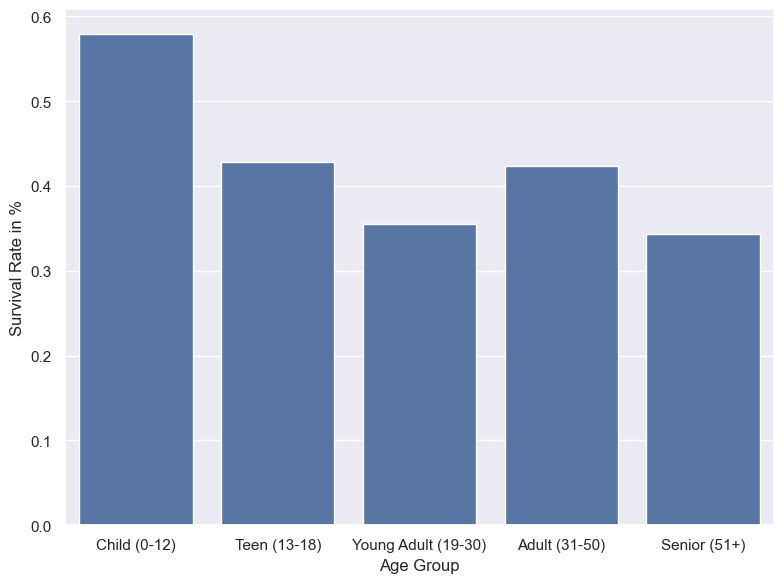

In [204]:
# Insights:
# Highest Survival Rate in children followed by teens + adults
# Seniors + Young Adults have the wortst Survival Rate

plt.figure(figsize=(8,6))
sns.barplot(x=survival_rates.index, y=survival_rates.values)
plt.xlabel("Age Group")
plt.ylabel("Survival Rate in %")

plt.tight_layout()
save_fig("survival_rate")

### Class distribution

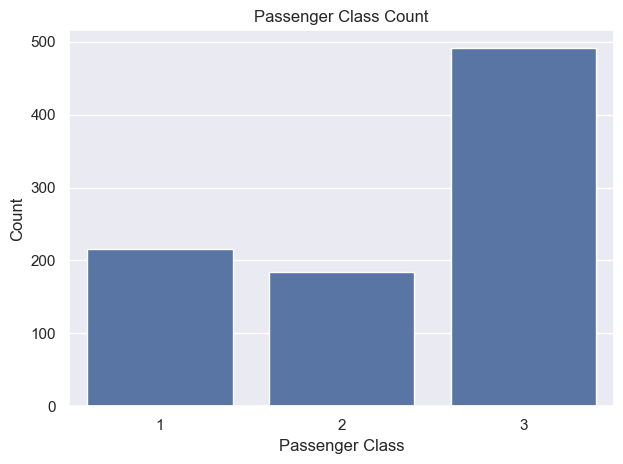

In [172]:
# Insights:
# Much more class 3 tickets than class 2 or class 1 ticktes

sns.barplot(df["Pclass"].value_counts())
plt.title("Passenger Class Count")
plt.xlabel("Passenger Class")
plt.ylabel("Count")
save_fig("class_distribution")

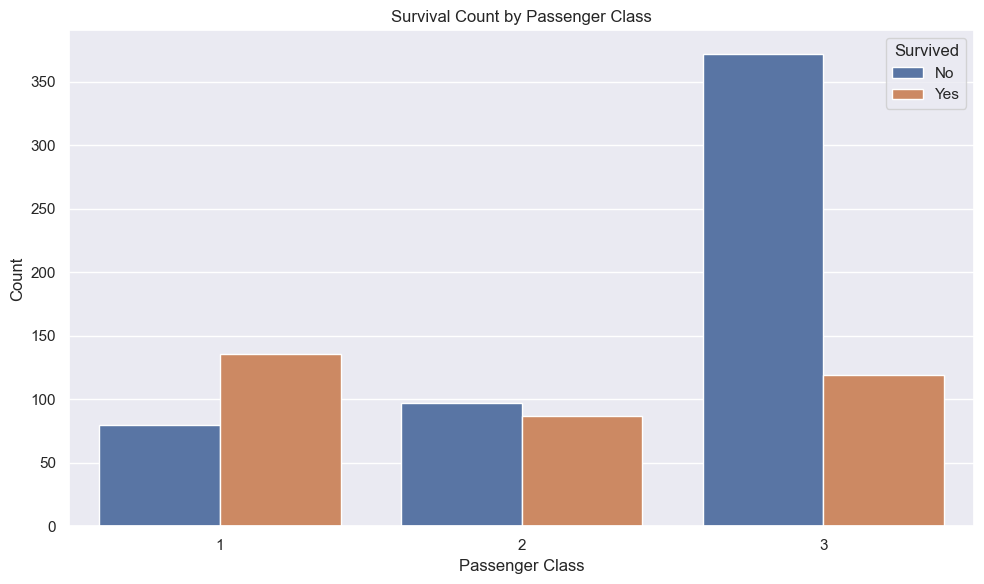

In [205]:
# Insights:
# Survival Rate correlates with Class (Class 1 higher SR > Class 2 > Class 3)

plt.figure(figsize=(10, 6))

# Create a countplot with hue to show survival by class
sns.countplot(data=df, x="Pclass", hue="Survived")
plt.title("Survival Count by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
save_fig("survival_by_class")


In [240]:
df.groupby("Pclass")["Survived"].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Check Port of Embarkation

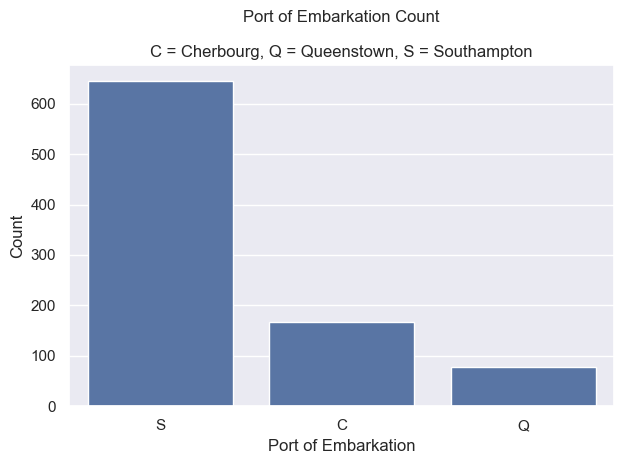

In [206]:
# Insights:
# Most people embarked from Southampton

sns.barplot(df["Embarked"].value_counts())
plt.title("Port of Embarkation Count\n\nC = Cherbourg, Q = Queenstown, S = Southampton")
plt.xlabel("Port of Embarkation")
plt.ylabel("Count")

save_fig("Port_distribution")

Gender distribution

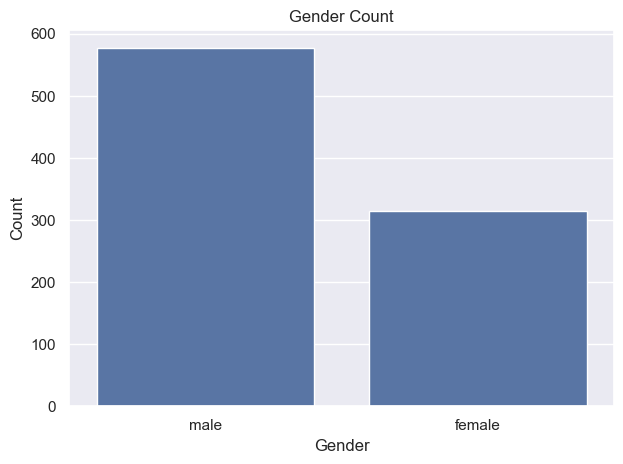

In [207]:
# Insights:
# More male passengers onbaord

sns.barplot(df["Sex"].value_counts())
plt.title("Gender Count")
plt.xlabel("Gender")
plt.ylabel("Count")

save_fig("geder_distribution")

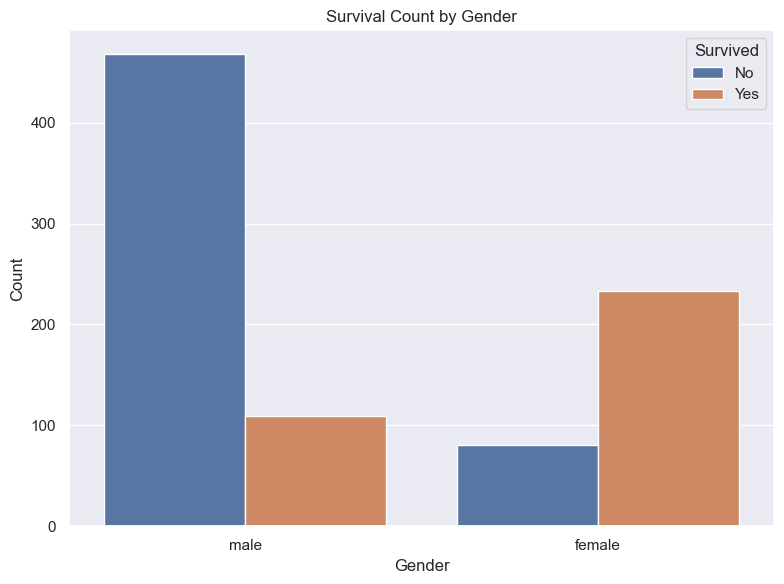

In [208]:
# Insights:
# Likelihood of survival is higher when female

plt.figure(figsize=(8,6))
sns.countplot(data=df, x="Sex", hue="Survived")
plt.title("Survival Count by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
save_fig("survival_by_gender")

In [244]:
df.groupby("Sex")["Survived"].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

### Visual for the Blog

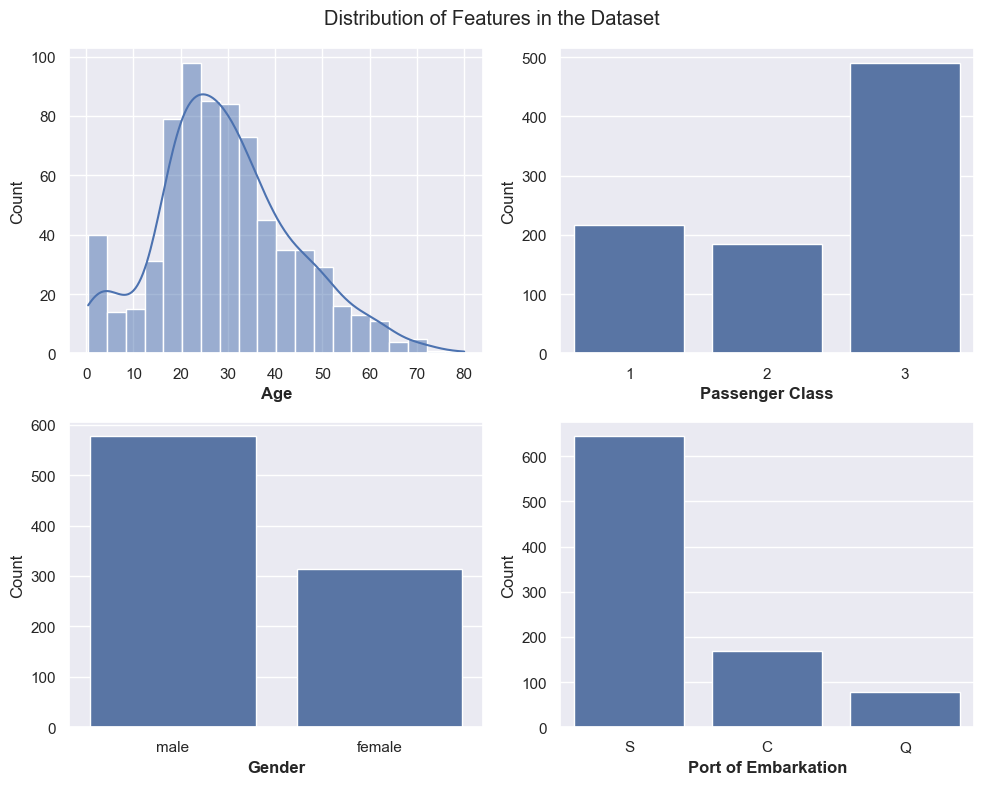

In [236]:
fig, axes = plt.subplots(2,2, figsize=(10,8))
plt.suptitle("Distribution of Features in the Dataset")

plt.sca(axes[0,0])
sns.histplot(df, x="Age", kde=True, ax=axes[0,0])
plt.xlabel("Age", weight="semibold")

plt.sca(axes[0,1])
sns.barplot(df["Pclass"].value_counts(), ax=axes[0,1])
plt.xlabel("Passenger Class", weight="semibold")
plt.ylabel("Count")

plt.sca(axes[1,0])
sns.barplot(df["Sex"].value_counts(), ax=axes[1,0])
plt.xlabel("Gender", weight="semibold")
plt.ylabel("Count")

plt.sca(axes[1,1])
sns.barplot(df["Embarked"].value_counts(), ax=axes[1,1])
plt.xlabel("Port of Embarkation", weight="semibold")
plt.ylabel("Count")


plt.tight_layout()
save_fig("Distribution_of_features")

### Combined Analysis: Multiple Factors


In [210]:
# pivot table showing survival rate by class and gender
survival_pivot = df.groupby(["Pclass", "Sex"])["Survived"].mean().unstack()
survival_pivot

Sex,female,male
Pclass,,
1,0.968085,0.368852
2,0.921053,0.157407
3,0.500000,0.135447


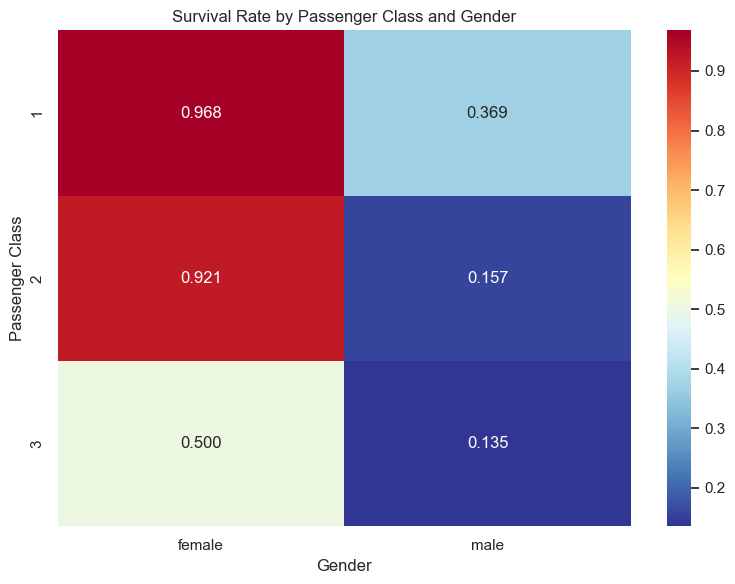

In [211]:
# Insights:
# Surivival Rate is higher in woman than in men
# Surivval Rate decreases from Passenger Class 1 to 3 in both men and women

# Heatmap showing survival rate by class and gender
plt.figure(figsize=(8, 6))
sns.heatmap(survival_pivot, annot=True, fmt='.3f', cmap='RdYlBu_r')
plt.title("Survival Rate by Passenger Class and Gender")
plt.xlabel("Gender")
plt.ylabel("Passenger Class")
save_fig("SR by Class and Gender")


In [254]:
survival_pivot2 = df.groupby(["Sex", "AgeGroup"], observed=True)["Survived"].mean().unstack().T
survival_pivot2

Sex,female,male
AgeGroup,,
Child (0-12),0.593750,0.567568
Teen (13-18),0.750000,0.088235
Young Adult (19-30),0.755556,0.155556
Adult (31-50),0.779070,0.225806
Senior (51+),0.941176,0.127660


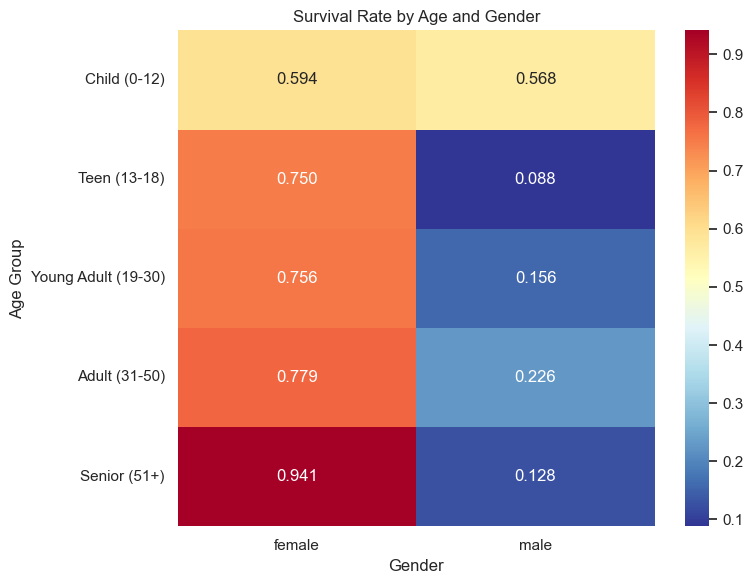

In [ ]:
# Insights:
# Survival Rate is much higher in women than in man, except in Children (0-12)

plt.figure(figsize=(8,6))
sns.heatmap(survival_pivot2, annot=True, fmt='.3f', cmap='RdYlBu_r')
plt.title("Survival Rate by Age and Gender")
plt.xlabel("Gender")
plt.ylabel("Age Group")

save_fig("SR by age and gender")

In [140]:
# Summary statistics table
print("=== SURVIVAL ANALYSIS SUMMARY ===")
print("\n1. Overall Survival Rate:")
overall_survival = df["Survived"].mean()
print(f"   Overall: {overall_survival:.3f} ({overall_survival*100:.1f}%)")

print("\n2. Survival Rate by Passenger Class:")
for pclass in sorted(df["Pclass"].unique()):
    rate = df[df["Pclass"] == pclass]["Survived"].mean()
    count = len(df[df["Pclass"] == pclass])
    print(f"   Class {pclass}: {rate:.3f} ({rate*100:.1f}%) - {count} passengers")

print("\n3. Survival Rate by Gender:")
for sex in df["Sex"].unique():
    rate = df[df["Sex"] == sex]["Survived"].mean()
    count = len(df[df["Sex"] == sex])
    print(f"   {sex}: {rate:.3f} ({rate*100:.1f}%) - {count} passengers")

print("\n4. Survival Rate by Age Groups:")
for age_group in df["AgeGroup"].dropna().unique():
    rate = df[df["AgeGroup"] == age_group]["Survived"].mean()
    count = len(df[df["AgeGroup"] == age_group])
    print(f"   {age_group}: {rate:.3f} ({rate*100:.1f}%) - {count} passengers")


=== SURVIVAL ANALYSIS SUMMARY ===

1. Overall Survival Rate:
   Overall: 0.384 (38.4%)

2. Survival Rate by Passenger Class:
   Class 1: 0.630 (63.0%) - 216 passengers
   Class 2: 0.473 (47.3%) - 184 passengers
   Class 3: 0.242 (24.2%) - 491 passengers

3. Survival Rate by Gender:
   male: 0.189 (18.9%) - 577 passengers
   female: 0.742 (74.2%) - 314 passengers

4. Survival Rate by Age Groups:
   Young Adult (19-30): 0.356 (35.6%) - 270 passengers
   Adult (31-50): 0.423 (42.3%) - 241 passengers
   Senior (51+): 0.344 (34.4%) - 64 passengers
   Child (0-12): 0.580 (58.0%) - 69 passengers
   Teen (13-18): 0.429 (42.9%) - 70 passengers


## Preprocessing

In [6]:
df = pd.read_csv("../data/titanic/train.csv")

Creating a training and a test set

In [8]:
X = df.drop("Survived", axis=1)

In [9]:
y = df["Survived"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [263]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("OneHot", OneHotEncoder(drop="if_binary"))
])

In [ ]:
# cabin present pipeline

def cabin_indicator(X):
    col = X.iloc[:, 0]
    return col.notna().astype(np.int64).to_numpy().reshape(-1, 1)

def cabin_name(function_transformer, feature_names_in):
    return ["cabin"]  # feature names out

def cabin_present_pipeline():
    return make_pipeline(
        FunctionTransformer(cabin_indicator, feature_names_out=cabin_name)
    )


In [305]:
# age groups pipeline

def group_age(X):
    values = pd.Series(X[:, 0], name="Age")
    grouped = pd.cut(values, bins=[0, 12, 18, 30, 50, 80], 
                       labels=["Child (0-12)", "Teen (13-18)", "Young Adult (19-30)", 
                              "Adult (31-50)", "Senior (51+)"], include_lowest=True)
    return grouped.to_numpy().reshape(-1,1)

def age_group_name(function_transformer, feature_names_in):
    return ["AgeGroup"]

def age_group_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(group_age, feature_names_out=age_group_name),
        OneHotEncoder(handle_unknown="ignore")
    )

In [332]:
# relatives on board

def relatives_sum(X):
    return X[:, [0]] + X[:, [1]]

def relatives_name():
    return ["relativesOnboard"]

def relatives_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="constant", fill_value=0),
        FunctionTransformer(relatives_sum, feature_names_out=relatives_name)
    )

In [333]:
preprocessing = ColumnTransformer([
    ("cabin_present", cabin_present_pipeline(), ["Cabin_present"]),
    ("age_group", age_group_pipeline(), ["Age"]),
    ("relatives_onboard", relatives_pipeline(), ["SibSp", "Parch"]),
    ("num", num_pipeline, ["Pclass", "Fare"]),
    ("cat", cat_pipeline, ["Sex", "Embarked"]),
],
remainder="drop"
)

## Training a Model

### Baseline models: looking for the most promising model before fine-tuning

**Stochastic Gradient Descent**

In [372]:
sgd_clf = make_pipeline(preprocessing, SGDClassifier(random_state=42))

In [373]:
sgd_scores = cross_val_score(sgd_clf, X_train, y_train, cv=10, scoring="accuracy")
sgd_scores

array([0.80555556, 0.73611111, 0.70422535, 0.78873239, 0.84507042,
       0.73239437, 0.76056338, 0.71830986, 0.67605634, 0.83098592])

**Support vector machine**

In [374]:
svm_clf = make_pipeline(preprocessing, SVC())

In [375]:
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10, scoring="accuracy")
svm_scores

array([0.88888889, 0.79166667, 0.74647887, 0.94366197, 0.87323944,
       0.77464789, 0.78873239, 0.78873239, 0.76056338, 0.91549296])

**DecisionTree**

In [376]:
decisionTree_clf = make_pipeline(preprocessing, DecisionTreeClassifier())

In [377]:
dt_scores = cross_val_score(decisionTree_clf, X_train, y_train, cv=10, scoring="accuracy")
dt_scores

array([0.80555556, 0.77777778, 0.74647887, 0.84507042, 0.84507042,
       0.77464789, 0.78873239, 0.8028169 , 0.76056338, 0.85915493])

**RandomForest**

In [378]:
randomForest_clf = make_pipeline(preprocessing, RandomForestClassifier())

In [379]:
rf_scores = cross_val_score(randomForest_clf, X_train, y_train, cv=10, scoring="accuracy")
rf_scores

array([0.75      , 0.77777778, 0.74647887, 0.83098592, 0.87323944,
       0.76056338, 0.78873239, 0.78873239, 0.81690141, 0.84507042])

### Comparing Models

In [380]:
model_list = [sgd_scores, svm_scores, dt_scores, rf_scores]

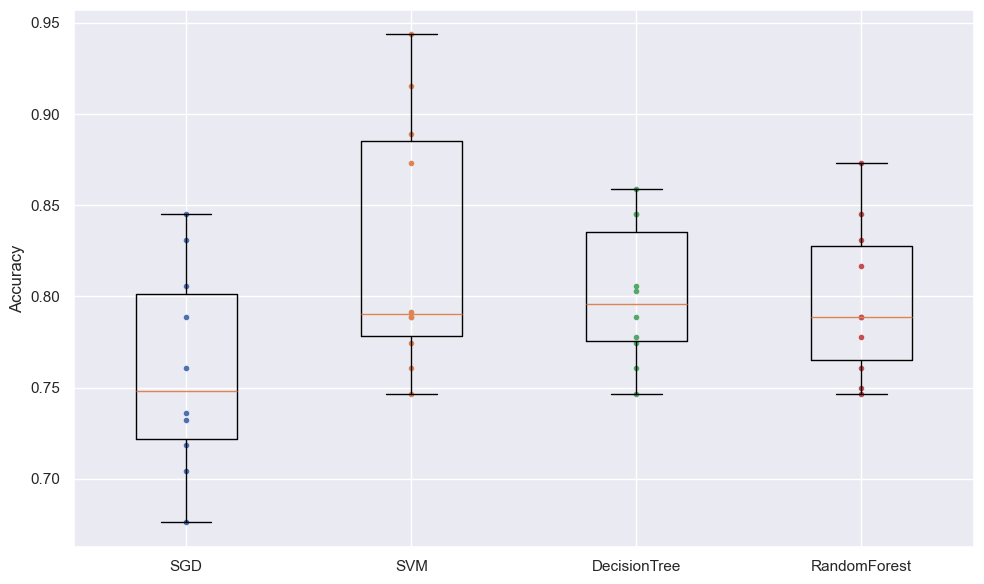

In [384]:
# Shows the accuracy by model

plt.figure(figsize=(10,6))
for i, model_name in enumerate(model_list, start=1):
    plt.plot([i]*10, model_name, ".")

plt.boxplot(model_list, labels=["SGD", "SVM", "DecisionTree", "RandomForest"])

#plt.xlabel("Model")
plt.ylabel("Accuracy")
save_fig("accuracy by model")

### Fine-tuning

**Support vector machine**

In [418]:
param_grid = {
    "svc__kernel": ["linear", "rbf"],
    "svc__C": [0.001, 0.01, 0.1, 1, 10],
    "svc__gamma": [0.001, 0.01, 0.1, 1, 10]
}

svm_tuned = GridSearchCV(svm_clf, param_grid=param_grid, cv=3, scoring="accuracy", n_jobs=-1)
svm_tuned.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('cabin_present',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<function cabin_name at 0x000001A948257740>,
                                                                                                              func=<function cabin_indicator at 0x000001A948257100>))]),
                                                                         ['Cabin_present']),
                                                                        ('age_group',
                                                                         Pipeline(steps=[('simpleimputer...
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Pclass',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('OneHot',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         ['Sex',
                                                                          'Embarked'])])),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 10],
                         'svc__gamma': [0.001, 0.01, 0.1, 1, 10],
                         'svc__kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [419]:
svm_tuned.best_score_

0.8244335708967131

In [387]:
svm_tuned.best_params_

{'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

## Performance Metrics

### Accuracy

1. Accuracy
- What it measures: Overall correctness (correct predictions / total predictions)
- Formula: (TP + TN) / (TP + TN + FP + FN)
- When to use: When classes are balanced and false positives/negatives have similar costs
- Limitation: Can be misleading with imbalanced datasets

In [388]:
# 1. model = make_pipeline(preprocessing, SVC(C=1, gamma=0.1, kernel="rbf"))
model =  make_pipeline(preprocessing, SVC(C=1, gamma=0.1, kernel="rbf"))

In [436]:
cross_val_score(model, X_train, y_train, cv=10, scoring="accuracy").mean()

0.8300078247261344

### Confusion Matrix

2. Confusion Matrix
- What it shows: A 2x2 table showing TP, TN, FP, FN counts
- Purpose: Foundation for calculating other metrics; shows where model makes mistakes
- Key insight: Visual representation of model performance breakdown

In [422]:
y_pred = cross_val_predict(model, X_train, y_train, cv=10)

In [423]:
cm = confusion_matrix(y_train, y_pred)
cm

array([[398,  46],
       [ 75, 193]], dtype=int64)

### Precision & Recall

3. Precision
- What it measures: "Of items predicted as positive, how many were actually positive?"
- Formula: TP / (TP + FP)
- When to prioritize: When false positives are costly (e.g., fraud detection, spam filtering)
- Interpretation: "How confident can I be when the model says 'positive'?"

In [424]:
precision_score(y_train, y_pred)

0.8075313807531381

4. Recall (Sensitivity)
- What it measures: "Of all actual positives, how many did I correctly identify?"
- Formula: TP / (TP + FN)
- When to prioritize: When false negatives are costly (e.g., medical diagnosis, security threats)
- Interpretation: "How many positives did I miss?"

In [425]:
recall_score(y_train, y_pred)

0.7201492537313433

5. F1-Score
- What it measures: Harmonic mean of precision and recall
- Formula: 2 × (precision × recall) / (precision + recall)
- When to use: When you need a single metric balancing precision and recall
- Best for: Imbalanced datasets where both precision and recall matter

In [426]:
f1_score(y_train, y_pred)

0.7613412228796843

### Precision/Recall Tradeoff

Most classifiers don't just make binary decisions - they output a score/probability. By adjusting the decision threshold, you can control the precision/recall tradeoff:

- **Higher threshold** → Higher precision, lower recall (fewer false positives, more false negatives)
- **Lower threshold** → Lower precision, higher recall (more false positives, fewer false negatives)

The precision-recall curve shows this tradeoff across all possible thresholds. You can use this to:
1. Find the optimal threshold for your specific needs
2. Compare different models
3. Understand how sensitive your model is to threshold changes


In [427]:
y_scores = cross_val_predict(model, X_train, y_train, cv=3, method="decision_function")

In [428]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

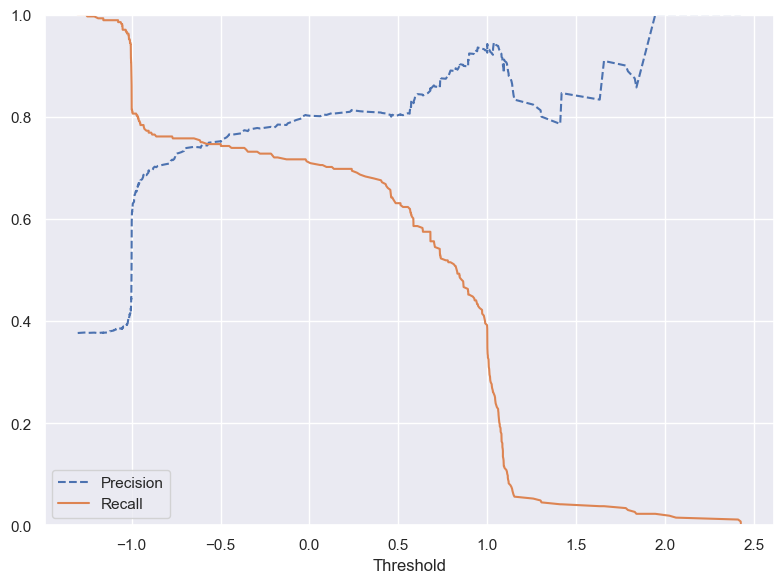

In [429]:
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], "--", label="Precision")
plt.plot(thresholds, recalls[:-1], "-", label="Recall")

plt.xlabel("Threshold")
plt.legend(loc="best")
plt.ylim([0, 1])
plt.tight_layout()
plt.show()



### Precision Recall Curve

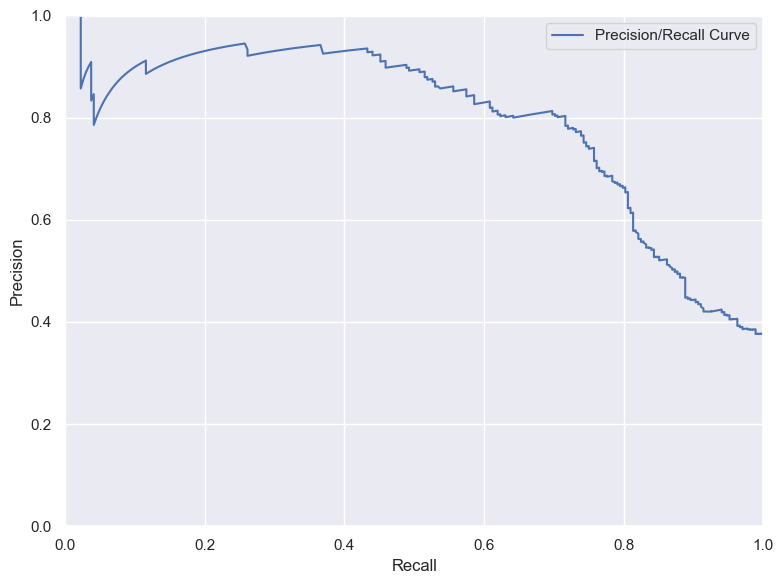

In [430]:
plt.figure(figsize=(8,6))
plt.plot(recalls, precisions, label="Precision/Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
#plt.axis([0,1,0,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.tight_layout()

save_fig("precision_recall_curve")

### ROC Curve

In [431]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

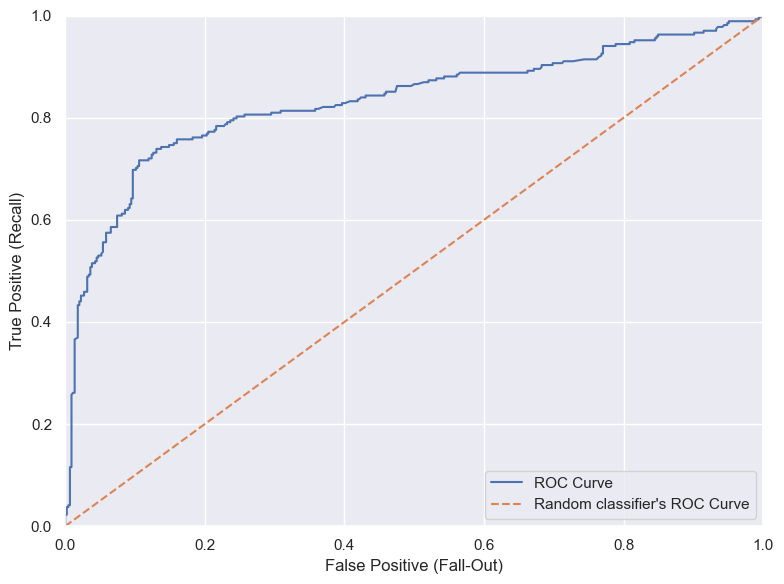

In [432]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1], [0,1], "--", label="Random classifier's ROC Curve")
plt.axis([0,1,0,1])

plt.xlabel("False Positive (Fall-Out)")
plt.ylabel("True Positive (Recall)")
plt.legend(loc="lower right")
plt.tight_layout()

save_fig("roc_curve_svm")

In [437]:
roc_auc_score(y_train, y_scores)

0.831866848191475

### Final Metric on the test set

In [438]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cabin_present',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function cabin_name at 0x000001A948257740>,
                                                                                       func=<function cabin_indicator at 0x000001A948257100>))]),
                                                  ['Cabin_present']),
                                                 ('age_group',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='me...
                                                                                       func=<function relatives_sum at 0x000001A94D1E4720>))]),
                                                  ['SibSp', 'Parch']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pclass', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('OneHot',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['Sex', 'Embarked'])])),
                ('svc', SVC(C=1, gamma=0.1))])

In [439]:
y_pred = model.predict(X_test)

In [453]:
accuracy_score(y_test, y_pred)

0.8156424581005587

In [441]:
precision_score(y_test, y_pred)

0.8059701492537313

In [442]:
recall_score(y_test, y_pred)

0.7297297297297297

In [452]:
f1_score(y_test, y_pred)

0.7659574468085106

## Predict on Test Data

In [443]:
df_test = pd.read_csv("../data/titanic/test.csv")

In [444]:
df_test["Cabin_present"] = df_test["Cabin"].notna().astype(int)

In [445]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_present
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


In [446]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    418 non-null    int64  
 1   Pclass         418 non-null    int64  
 2   Name           418 non-null    object 
 3   Sex            418 non-null    object 
 4   Age            332 non-null    float64
 5   SibSp          418 non-null    int64  
 6   Parch          418 non-null    int64  
 7   Ticket         418 non-null    object 
 8   Fare           417 non-null    float64
 9   Cabin          91 non-null     object 
 10  Embarked       418 non-null    object 
 11  Cabin_present  418 non-null    int32  
dtypes: float64(2), int32(1), int64(4), object(5)
memory usage: 37.7+ KB


In [447]:
df_test["Survived"] = model.predict(df_test)

In [448]:
df_test[["PassengerId", "Survived"]].to_csv("../data/titanic/titanic_predictions.csv", index=False)

In [449]:
df_t = pd.read_csv("../data/titanic/titanic_predictions.csv")

In [450]:
df_t.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [451]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB
